# Make global spectral slope maps for ONC and NIRS3

In [1]:
# Set output folder
out_folder = './output/'

In [2]:
import numpy as np
import math
import rasterio
from rasterio import features
from rasterio.transform import Affine
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

## Calculate NUV, VIS spectral slope maps using ONC data

In [3]:
#Input file: ONC multi-band mosaic map (GeoTIFF)
in_raster = './data/hyb2_onc_mos_20181003_MascotSeparation.tif'

with rasterio.open(in_raster) as raster:
    data = raster.read()

print("Shape of data:", data.shape)
print("Data type: ", data.dtype)

Shape of data: (7, 1436, 10001)
Data type:  float32


In [4]:
# Save as GeoTIFF file
def out_raster(opath,data,rst,d_type):
    of=rasterio.open(opath , 'w', driver='COG',
                height=rst.shape[0], width=rst.shape[1], count=1,
                dtype=d_type, crs=rst.crs, transform=rst.transform, nodata = -999)

    of.write(data,1)
    of.close()


-1.0 0.026892293


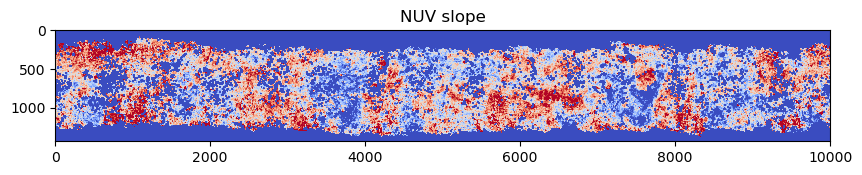

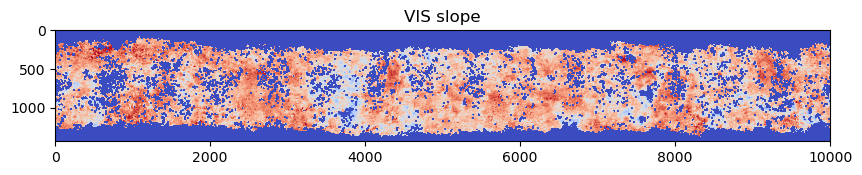

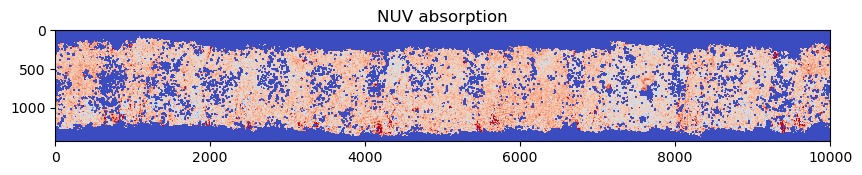

In [5]:
# ONC filter wavelengths (ul,b,v,Na,w,x,p) micron
wl = [0.40, 0.48, 0.55, 0.59, 0.70, 0.86, 0.95]

#calculate spectral slopes
# NUV(v-to-ul) spectral slope
slope_nuv = (data[2,:,:] - data[0,:,:])/data[2,:,:]/(wl[2]-wl[0])
# VIS(v-to-x) spectral slope
slope_vis = (data[5,:,:] - data[2,:,:])/data[2,:,:]/(wl[5]-wl[2])

print(np.min(data[2]), np.max(data[2]))
# NUV absorption (A_UV) is defined as a difference between NUV and VIS slopes
a_uv = slope_nuv - slope_vis

# Put -999 as nodata value
slope_nuv[data[2] == -1] = -999
slope_vis[data[2] == -1] = -999
a_uv[data[2] == -1] = -999

plt.figure(figsize = (10,4))
plt.imshow(slope_nuv, cmap='coolwarm',vmin=-0.5, vmax=-0.4)
#plt.colorbar()  # show color scale
plt.title("NUV slope")
plt.show()

plt.figure(figsize = (10,4))
plt.imshow(slope_vis, cmap='coolwarm',vmin=0, vmax=0.2)
plt.title("VIS slope")
plt.show()

plt.figure(figsize = (10,4))
plt.imshow(a_uv, cmap='coolwarm',vmin=-0.7, vmax=-0.5)
plt.title("NUV absorption")
plt.show()

In [6]:
#Output GeoTIFF files
#slope_nuv
opath = out_folder + 'ONC_MSC_slope_nuv.tif'
a = out_raster(opath,slope_nuv,raster,data.dtype)

#slope_vis
opath = out_folder + 'ONC_MSC_slope_vis.tif'
a = out_raster(opath,slope_vis,raster,data.dtype)

#a_uv
opath = out_folder + 'ONC_MSC_a_uv.tif'
a = out_raster(opath,a_uv,raster,data.dtype)

## Calculate NIR spectral slope using NIRS3 data

In [7]:
# Set NIRS3 spectral wavelength (micron) (ref. SIS document)
n=np.arange(128)+1
wl_all=(1230.33+18.5651*n-0.00492138*n**2)/1000.

# Input file: NIRS3 geopackage file
in_vector = './data/hyb2_nirs3_20180711_01_l2d_geo.gpkg'

# Read the input file
vector = gpd.read_file(in_vector)
df = pd.DataFrame(vector)

df.head()

,Observation time (UTC),Phase angle,Incidence angle,Emission angle,Temperature,wl1,wl2,wl3,wl4,wl5,...,wl120,wl121,wl122,wl123,wl124,wl125,wl126,wl127,wl128,geometry
0,2018-07-11T06:17:09.3Z,17.988404,71.366567,66.190579,338.0,-4.265375e-10,-0.000248,0.000134,0.000235,0.000062,...,0.610887,0.810512,1.364987,2.088861,3.446077,6.523120,10.570072,15.467841,22.238959,"POLYGON ((236.85492 70.54766, 252.90254 71.791..."
1,2018-07-11T06:17:10.7Z,17.999855,70.808254,68.820434,339.0,-4.716538e-10,-0.000068,0.000024,0.000391,0.000023,...,0.414088,0.808821,1.419668,2.293199,3.472873,6.588190,11.179749,16.457655,23.928824,"POLYGON ((236.88354 60.5633, 248.21992 63.1159..."
2,2018-07-11T06:17:12.0Z,18.010804,69.695079,64.457322,337.0,-3.855068e-10,-0.000068,0.000055,0.000157,0.000023,...,0.486972,0.725088,1.110402,2.015161,3.501284,6.350557,10.932321,15.866783,22.404084,"POLYGON ((236.88681 50.6798, 245.44851 53.6524..."
3,2018-07-11T06:17:13.4Z,18.022934,70.774746,65.245027,334.0,-2.835817e-10,0.000183,-0.000103,-0.000388,-0.000042,...,0.249678,0.349029,0.911646,1.742294,2.959888,5.434655,9.531462,13.668583,20.755034,"POLYGON ((236.87903 40.53913, 243.53686 43.356..."
4,2018-07-11T06:17:14.7Z,18.033969,73.027679,60.998980,338.0,-4.265375e-10,0.000004,0.000103,0.000157,0.000036,...,0.450894,0.986073,1.415702,2.407662,3.772057,7.195858,11.856942,16.057200,23.379476,"POLYGON ((236.90174 33.43934, 242.52461 35.407..."


In [8]:
# Get the sum of polygon values and put as a raster
def poly_to_raster(shapes,shape,transform,d_type):
    rsted = features.rasterize(shapes,
                                #out_shape = rst.shape,
                                out_shape = shape,
                                fill = 0,
                                out = None,
                                default_value = 1,
                                #transform = rst.transform,
                                transform = transform,
                                all_touched = True,
                                merge_alg=rasterio.enums.MergeAlg.add,
                                dtype = d_type)
    return rsted

# Save a raster file as GeoTIFF

def out_raster(opath,data,shape,crs,transform,cnl,d_type,nodata):
    of=rasterio.open(opath , 'w', driver='COG',
                height=shape[0], width=shape[1], count=cnl,
                dtype=d_type, crs=crs, transform=transform, nodata = nodata)
    if cnl == 1:
        of.write(data,1)
        of.close()
    else:
        of.write(data)
        of.close()

In [9]:
# Parameter setting
# Select the wavelength bands to be used
cnl_conv = ['wl47','wl70']
wl_start = cnl_conv[0]
wl_end = cnl_conv[1]

# Set the data type
d_type = 'float32'
d_type_cnt = 'int16'

#resolution [degree/pixel]
res = 1.0

# Output image size [deg]
px = 360
py = 180

# Upper left coordinate [deg]
ulx = 0
uly = 90

# Set nodata value
nodata = -999
nodata_cnt = 0

In [10]:
# Convert from polygon to raster
transform = Affine(res,0,ulx,0,res,uly*(-1))
width = int(px/res)
height = int(py/res)
shape = (height, width)

cnl = len(cnl_conv)

if cnl == 1:
    ave_arr =np.empty((height, width),dtype = float)
else:
    ave_arr =np.empty((cnl,height, width),dtype = float)

cnt_arr =np.empty((height, width),dtype = float)

k = 0
for ff in cnl_conv:
    geom = [(s,i) for s,i in zip(vector['geometry'],vector[ff])]
    geom_bi = [(s,1) for s in vector['geometry']]

    if cnl == 1:
        cnt_arr = poly_to_raster(geom_bi,shape,transform,d_type_cnt)
        merge = poly_to_raster(geom,shape,transform,d_type)
        ave_arr[:,:] = np.where(cnt_arr!=0,merge/cnt_arr,-999)

    else:
        if k == 0:
            cnt_arr = poly_to_raster(geom_bi,shape,transform,d_type_cnt)
        merge = poly_to_raster(geom,shape,transform,d_type)
        ave_arr[k,:,:] = np.where(cnt_arr!=0,merge/cnt_arr,-999)

    k = k + 1

# Calculate spectral slope between channel 47 to channel 70
slope = (ave_arr[1,:,:] - ave_arr[0,:,:])/ave_arr[0,:,:]/(wl_all[70]-wl_all[47])
slope[cnt_arr == 0] = -999

/var/folders/nf/8_y6y1417fg912krtr261zk40000gp/T/ipykernel_57909/4153235562.py:30: RuntimeWarning: invalid value encountered in divide
  ave_arr[k,:,:] = np.where(cnt_arr!=0,merge/cnt_arr,-999)
/var/folders/nf/8_y6y1417fg912krtr261zk40000gp/T/ipykernel_57909/4153235562.py:30: RuntimeWarning: invalid value encountered in divide
  ave_arr[k,:,:] = np.where(cnt_arr!=0,merge/cnt_arr,-999)


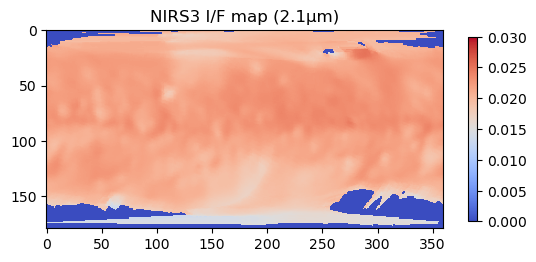

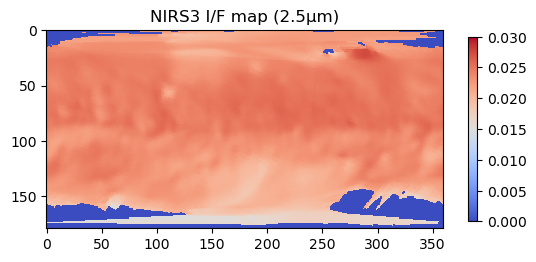

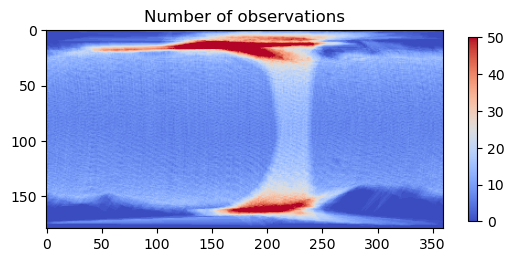

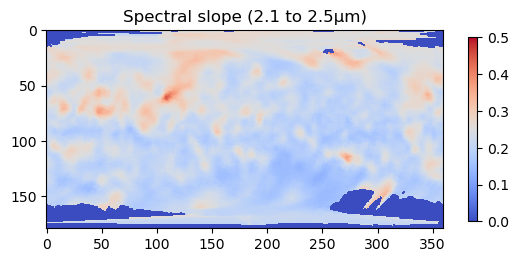

In [11]:
plt.imshow(ave_arr[0,:,:], cmap='coolwarm',vmin=0, vmax=0.03)
plt.colorbar(shrink=0.5) 
plt.title("NIRS3 I/F map (2.1μm)")
plt.show()

plt.imshow(ave_arr[1,:,:], cmap='coolwarm',vmin=0, vmax=0.03)
plt.colorbar(shrink=0.5) 
plt.title("NIRS3 I/F map (2.5μm)")
plt.show()

plt.imshow(cnt_arr, cmap='coolwarm',vmin=0, vmax=50)
plt.title("Number of observations")
plt.colorbar(shrink=0.5)
plt.show()

plt.imshow(slope, cmap='coolwarm', vmin=0, vmax=0.5)
plt.title("Spectral slope (2.1 to 2.5μm)")
plt.colorbar(shrink=0.5)
plt.show()

In [12]:

# Set file paths
day = df.iloc[0,0][:10]
opath = out_folder + day + '_ave_' + str(res) + 'd.tif'
opath_cnt = out_folder + day + '_cnt_' + str(res) + 'd.tif'
opath_slope = out_folder + day + '_slp_' + str(res) + 'd.tif'


# Output data
crs = vector.crs
out_raster(opath,ave_arr,shape,crs,transform,cnl,d_type,nodata)
out_raster(opath_cnt,cnt_arr,shape,crs,transform,1,d_type_cnt,nodata_cnt)
out_raster(opath_slope,slope,shape,crs,transform,1,d_type,nodata)